In [10]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


## Load Data
Loads the fraud and credit card datasets from CSV files. Handles missing file errors gracefully by printing an error message.

In [11]:
# Load the datasets
try:
    fraud_df = pd.read_csv('../data/processed/cleaned_fraud_data.csv')
    credit_df = pd.read_csv('../data/processed/cleaned_credit_data.csv')
except FileNotFoundError as e:
    print(f"Error: {e}. Please check the file paths.")

## Fraud Data: Train/Test Split, SMOTE, and Scaling
Prepares the fraud dataset for modeling: drops the target column, one-hot encodes categorical variables, splits the data, balances classes using SMOTE, and scales the 'Amount' feature.

In [12]:
# Prepare fraud detection data
# Assuming 'class' is the target variable in fraud_df
Xf = fraud_df.drop(columns=['class', 'signup_time', 'purchase_time', 'device_id'])
yf = fraud_df['class']

# One-hot encode before sampling
Xf = pd.get_dummies(Xf, columns=['source','browser','sex','country'], drop_first=True)


Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, stratify=yf, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
Xf_train_resampled, yf_train_resampled = smote.fit_resample(Xf_train, yf_train)

scaler = StandardScaler()
# Only scale 'Amount'
Xf_train_resampled['purchase_value'] = scaler.fit_transform(Xf_train_resampled[['purchase_value']])
Xf_test['purchase_value'] = scaler.transform(Xf_test[['purchase_value']])


## Credit Card Data: Train/Test Split, SMOTE, and Scaling
Prepares the credit card dataset for modeling: drops the target column, splits the data, balances classes using SMOTE, and scales the 'Amount' feature.

In [13]:
# Prepare credit card fraud data
# Assuming 'Class' is the target variable in credit_df
Xc = credit_df.drop(columns='Class')
yc = credit_df['Class']


Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, stratify=yc, test_size=0.3, random_state=42)

# smote for credit card fraud data
smote = SMOTE(random_state=42)
Xc_train_resampled, yc_train_resampled = smote.fit_resample(Xc_train, yc_train)

scaler = StandardScaler()
# Only scale 'Amount'
Xc_train_resampled['Amount'] = scaler.fit_transform(Xc_train_resampled[['Amount']])
Xc_test['Amount'] = scaler.transform(Xc_test[['Amount']])

In [14]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression models
# Using max_iter=1000 to ensure convergence
log_fraud = LogisticRegression(max_iter=1000, random_state=42)
log_fraud.fit(Xf_train_resampled, yf_train_resampled)

log_credit = LogisticRegression(max_iter=1000, random_state=42)
log_credit.fit(Xc_train_resampled, yc_train_resampled)

/home/est-lul/Documents/Projects/fraud_detection/.venv/lib64/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

In [15]:
from xgboost import XGBClassifier

# Train XGBoost models with appropriate scale_pos_weight
# Adjust scale_pos_weight based on the class imbalance
# For fraud detection, we assume a lower imbalance, hence a lower scale_pos_weight

xgb_fraud = XGBClassifier(scale_pos_weight=10, use_label_encoder=False, eval_metric='logloss')
xgb_fraud.fit(Xf_train_resampled, yf_train_resampled)

# For credit card fraud, we assume a higer imbalance, hence a higer scale_pos_weight
xgb_credit = XGBClassifier(scale_pos_weight=50, use_label_encoder=False, eval_metric='logloss')
xgb_credit.fit(Xc_train_resampled, yc_train_resampled)

/home/est-lul/Documents/Projects/fraud_detection/.venv/lib64/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:56:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/est-lul/Documents/Projects/fraud_detection/.venv/lib64/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:57:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, f1_score

def evaluate_model(model, X_test, y_test):
    """
    Evaluates a classification model's performance on test data.

    Prints the confusion matrix, classification report, F1 score, and area under the precision-recall curve (AUC-PR).
    
    Parameters:
        model: Trained classification model with predict and predict_proba methods.
        X_test: Test features.
        y_test: True labels for test data.
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auc_pr = auc(recall, precision)
    f1 = f1_score(y_test, y_pred)

    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-PR: {auc_pr:.4f}")

# Evaluate models on test data
evaluate_model(log_fraud, Xf_test, yf_test)
evaluate_model(xgb_fraud, Xf_test, yf_test)

evaluate_model(log_credit, Xc_test, yc_test)
evaluate_model(xgb_credit, Xc_test, yc_test)


Confusion Matrix:
 [[28399 12690]
 [ 1391  2854]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.69      0.80     41089
           1       0.18      0.67      0.29      4245

    accuracy                           0.69     45334
   macro avg       0.57      0.68      0.54     45334
weighted avg       0.88      0.69      0.75     45334

F1 Score: 0.2884
AUC-PR: 0.2803
Confusion Matrix:
 [[21789 19300]
 [  717  3528]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.53      0.69     41089
           1       0.15      0.83      0.26      4245

    accuracy                           0.56     45334
   macro avg       0.56      0.68      0.47     45334
weighted avg       0.89      0.56      0.65     45334

F1 Score: 0.2606
AUC-PR: 0.6724
Confusion Matrix:
 [[84504   791]
 [   22   126]]
Classification Report:
               precision    recall  f1-score   support

     

In [17]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

/home/est-lul/Documents/Projects/fraud_detection/.venv/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
explainer = shap.TreeExplainer(xgb_fraud)
shap_values = explainer.shap_values(Xf_test)

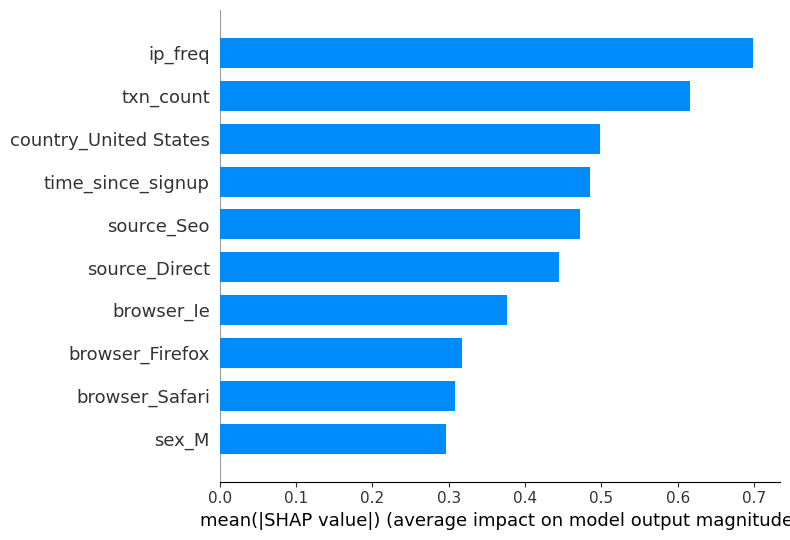

In [19]:
shap.summary_plot(shap_values, Xf_test, plot_type="bar", max_display=10)

In [20]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], Xf_test.iloc[0])

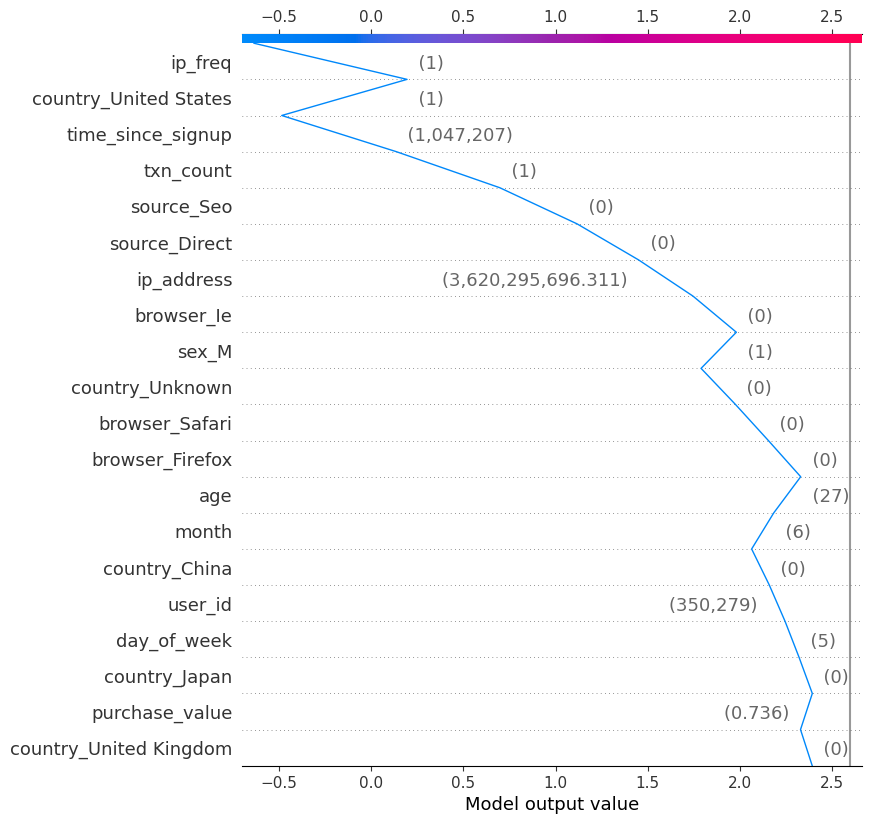

In [21]:
shap.decision_plot(explainer.expected_value, shap_values[0], Xf_test.iloc[0])